In [1]:
%load_ext autoreload
%autoreload 2

import os
cwd = os.getcwd()
sep = os.path.sep
final_wd = sep.join(cwd.split(sep)[:-1])
print(final_wd)
os.chdir(final_wd)

/home


In [2]:
import constants as ct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

os.listdir(ct.DATA_FOLDER)

['.ipynb_checkpoints', 'infoenergia-0106741-05022019.csv']

In [3]:
FIXED_COST = 0.044027
KWH_PRICE = 0.139 + FIXED_COST
KWH_PRICE

0.183027

In [4]:
LOW_COST = 0.082 + FIXED_COST
HIGH_COST = 0.161 + FIXED_COST
LOW_COST, HIGH_COST

(0.126027, 0.20502700000000001)

In [5]:
!head -n 5 data/infoenergia-0106741-05022019.csv

ES0031102224538009AP0F;01/01/2019;00:00:00;0;1
ES0031102224538009AP0F;02/01/2019;00:00:00;0;1
ES0031102224538009AP0F;03/01/2019;00:00:00;0;1
ES0031102224538009AP0F;04/01/2019;00:00:00;0;1
ES0031102224538009AP0F;05/01/2019;00:00:00;0;1


In [6]:
df = pd.read_csv(ct.HOURLY_CONSUMPTION_FILE_PATH, 
                 sep=';', 
                 header=None)
df.columns = ['account_name', 'date', 'hour', 'kwh', 'flag']
df.kwh = df.kwh.astype('float').div(1000.0)
df.drop(['account_name', 'flag'], inplace=True, axis=1)
df.insert(0, 'hourly_timestamp', pd.to_datetime(df.date.str.cat(df.hour, sep='T'), 
                                                format="%d/%m/%YT%H:%M:%S"))

df = df.loc[df.hourly_timestamp.gt('2019-02-15') & df.hourly_timestamp.lt('2019-12-09')]

df['holiday'] = np.nan
df.holiday = df.holiday.astype('Int32')
df.loc[df.hourly_timestamp.between('2019-04-16', '2019-04-22', inclusive=True), 'holiday'] = 1
df.loc[df.hourly_timestamp.between('2019-08-16', '2019-08-19', inclusive=True), 'holiday'] = 1
df.loc[df.hourly_timestamp.between('2019-08-21', '2019-08-26', inclusive=True), 'holiday'] = 1
df.loc[df.hourly_timestamp.between('2019-08-29', '2019-09-01', inclusive=True), 'holiday'] = 1


def get_feat_eng(df):
    feat_eng_df = df.copy()
    feat_eng_df['date'] = feat_eng_df.hourly_timestamp.dt.to_period('D')
    feat_eng_df['yearmonth'] = feat_eng_df.hourly_timestamp.dt.to_period('M')
    feat_eng_df['dow'] = feat_eng_df.hourly_timestamp.dt.weekday_name
    feat_eng_df['is_weekend'] = feat_eng_df.dow.isin(['Saturday', 'Sunday'])
    feat_eng_df['hour'] = feat_eng_df.hourly_timestamp.dt.hour
    feat_eng_df['is_working_time'] = feat_eng_df.hour.between(9, 19, inclusive=True)
    feat_eng_df['is_night_time'] = feat_eng_df.hour.between(0, 8, inclusive=True)
    feat_eng_df['cost'] = feat_eng_df.kwh.mul(KWH_PRICE)
    feat_eng_df['discriminative_cost'] = (feat_eng_df.kwh.mul(feat_eng_df.hour.between(12, 22))
                                                         .mul(HIGH_COST)
                                                         .add(
                                          feat_eng_df.kwh.mul(~feat_eng_df.hour.between(12, 22)).mul(LOW_COST)))
    
    feat_eng_df.set_index('hourly_timestamp', inplace=True)
    
    return feat_eng_df


df = get_feat_eng(df)
df.head()

,date,hour,kwh,holiday,yearmonth,dow,is_weekend,is_working_time,is_night_time,cost,discriminative_cost
hourly_timestamp,,,,,,,,,,,
2019-02-15 01:00:00,2019-02-15,1,0.107,NaN,2019-02,Friday,False,False,True,0.019584,0.013485
2019-02-15 02:00:00,2019-02-15,2,0.102,NaN,2019-02,Friday,False,False,True,0.018669,0.012855
2019-02-15 03:00:00,2019-02-15,3,0.100,NaN,2019-02,Friday,False,False,True,0.018303,0.012603
2019-02-15 04:00:00,2019-02-15,4,0.103,NaN,2019-02,Friday,False,False,True,0.018852,0.012981
2019-02-15 05:00:00,2019-02-15,5,0.099,NaN,2019-02,Friday,False,False,True,0.018120,0.012477


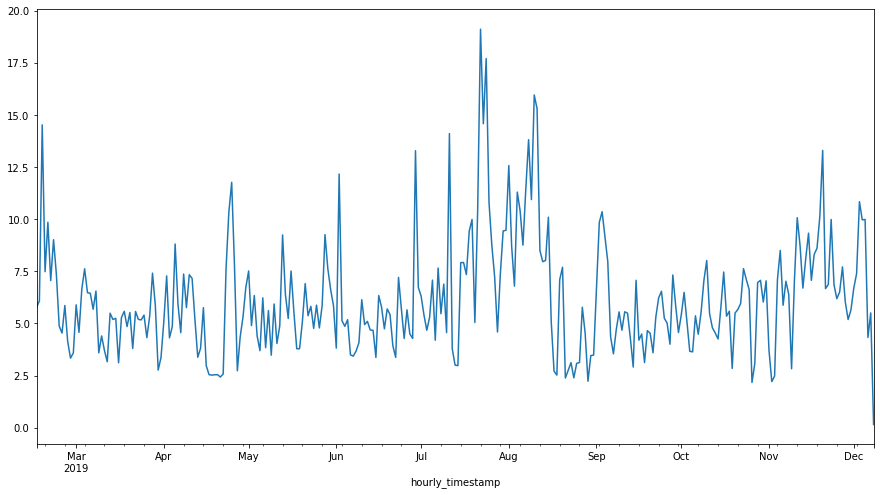

In [7]:
df.resample('1D').kwh.sum().plot(figsize=(15, 8));

# Empty house known consumption

Hourly basal consumption is the mode of the hourly consumption when the house is empty.

In [8]:
from scipy.stats.mstats import winsorize

WINSOR_PROP = 0.1

def take_mean_if_populated(series,
                           min_pop=0,
                           winsorize_lower=0.1,
                           winsorize_upper=0.1):
    not_null_arr = series

    if not_null_arr.size >= min_pop:
        winsorized_arr = np.array(winsorize(not_null_arr, limits=(winsorize_lower, winsorize_upper)))
        val = np.mean(winsorized_arr)
    else:
        val = np.nan

    return val


In [9]:
holiday_df = df.loc[df.holiday.eq(1)]

In [10]:
holiday_df.kwh.describe()

count    412.000000
mean       0.119716
std        0.055435
min        0.087000
25%        0.099750
50%        0.103000
75%        0.138000
max        0.768000
Name: kwh, dtype: float64

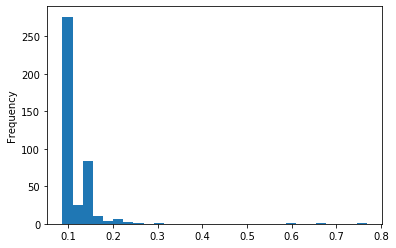

In [11]:
holiday_df.kwh.loc[df.holiday.eq(1)].plot.hist(bins=30);

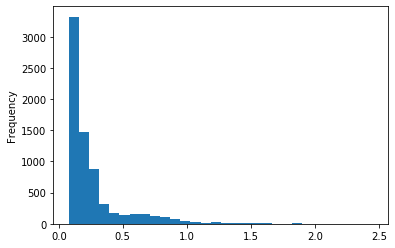

In [12]:
df.kwh.plot.hist(bins=30);

This is the true base load:

In [13]:
basal_hourly_consumption_winsorized_mean = np.mean(winsorize(holiday_df.kwh, limits=WINSOR_PROP))
basal_hourly_consumption_winsorized_mean

0.11348543689320388

In [14]:
estimated_basal_consumption_by_hour = holiday_df.groupby('hour').kwh.apply(take_mean_if_populated).min()
estimated_basal_consumption_by_hour

0.10370588235294118

# Basal consumption estimation

In [15]:
BASE_LOAD_QUANTILE_ESTIMATOR = 0.05

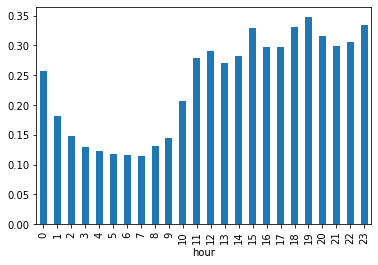

In [16]:
df.groupby('hour').kwh.apply(lambda series: take_mean_if_populated(series, 
                                                                   winsorize_lower=WINSOR_PROP,
                                                                   winsorize_upper=WINSOR_PROP)).plot.bar();

In [17]:
estimated_basal_consumption_by_hour = df.groupby('hour').kwh.apply(take_mean_if_populated).min()
estimated_basal_consumption_by_hour

0.11369594594594594

In [18]:
df.kwh.rolling('7D').quantile(BASE_LOAD_QUANTILE_ESTIMATOR)

hourly_timestamp
2019-02-15 01:00:00    0.10700
2019-02-15 02:00:00    0.10225
2019-02-15 03:00:00    0.10020
2019-02-15 04:00:00    0.10030
2019-02-15 05:00:00    0.09920
                        ...   
2019-12-07 20:00:00    0.08200
2019-12-07 21:00:00    0.08200
2019-12-07 22:00:00    0.08200
2019-12-07 23:00:00    0.08200
2019-12-08 00:00:00    0.08200
Name: kwh, Length: 7103, dtype: float64

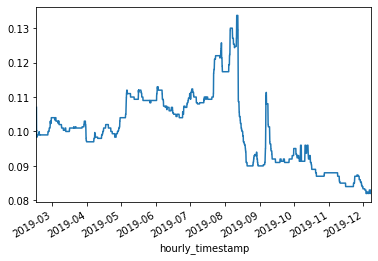

In [19]:
df.kwh.rolling('7D').quantile(BASE_LOAD_QUANTILE_ESTIMATOR).plot();

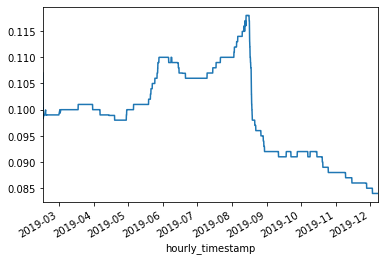

In [20]:
df.kwh.rolling('30D').quantile(BASE_LOAD_QUANTILE_ESTIMATOR).plot();

In [21]:
df.kwh.rolling('30D').quantile(BASE_LOAD_QUANTILE_ESTIMATOR).iloc[-1]

0.084

In [22]:
df.kwh.rolling('24H').quantile(BASE_LOAD_QUANTILE_ESTIMATOR).iloc[-1]

0.082

In [23]:
df.kwh.rolling('7D').quantile(BASE_LOAD_QUANTILE_ESTIMATOR).iloc[-1]

0.082

In [24]:
df.groupby('hour').kwh.apply(take_mean_if_populated).idxmin()

7

In [25]:
def get_current_basal_estimation(df, 
                                 winsor_prop=WINSOR_PROP, 
                                 base_load_quant_est=BASE_LOAD_QUANTILE_ESTIMATOR):

    ROLLING_STATISTIC_LIST = ['24H', '3D', '7D', '30D', '90D']

    base_load_hour = (df.groupby('hour')
                        .kwh
                        .apply(lambda series: take_mean_if_populated(series,
                                                                     winsorize_lower=winsor_prop,
                                                                     winsorize_upper=winsor_prop)).idxmin())
    print("Base load hour is %d" % base_load_hour)
    restricted_to_base_load_hour_df = df.loc[df.hour.eq(base_load_hour)]

    stats_df = pd.DataFrame(np.nan, index=ROLLING_STATISTIC_LIST, columns=[
                            'min_hour_mean', 'winsorized_mean'])

    for window_size in ROLLING_STATISTIC_LIST:

        min_hour_stat = (restricted_to_base_load_hour_df.kwh
                         .rolling(window_size)
                         .apply(lambda series: take_mean_if_populated(series,
                                                                      winsorize_lower=winsor_prop,
                                                                      winsorize_upper=winsor_prop),
                                raw=True)).iloc[-1]
        winsorized_stat = df.kwh.rolling(window_size).quantile(base_load_quant_est).iloc[-1]
        
        stats_df.loc[window_size, 'min_hour_mean'] = min_hour_stat
        stats_df.loc[window_size, 'winsorized_mean'] = winsorized_stat

    return stats_df


base_load_estimation = get_current_basal_estimation(df)
base_load_estimation

Base load hour is 7


,min_hour_mean,winsorized_mean
24H,0.084000,0.082
3D,0.085667,0.082
7D,0.092286,0.082
30D,0.094700,0.084
90D,0.097767,0.086


In [26]:
base_load_estimation.mean().mean()

0.08704190476190476